# Falling Rocks
I have to figure out how to create a seven unit wide matrix, that will grow in height - or just have an infinite height. 
Then I will have to create an object, that will be the current stone, which will be used to interact with the matrix. I think having a list of objects to draw from will be pretty neat. 

For a start I will create a single falling object, that falls straight and lands on top of the last object. After that I will implement new rocks and finally I will add the air.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import ast
import time

In [38]:
class Cave():
    """
    The cave class creates the initial empty cave, it has the functionality to interact with an object from the stone class.
    
    It is set, such that it will expand when more stones are added
    """
    
    def __init__(self,width,height,wind,dimensions = 3):
        self.width = width+1
        self.height = height+1
        self.dimensions = dimensions
        self.current_image = np.zeros((self.height,self.width,dimensions))
        self.wind_pattern = wind
        self.wind_que = wind
        
        """From the task description: each rock appears so that its left edge is two units away from the left wall 
        and its bottom edge is three units above the highest rock in the room (or the floor, if there isn't one).
        
        
        This is set, so the stone can initialize from the starting point defined by the cave"""
        self.rock_start = 5
        
        # Add white roof
        for column in range(self.width):
            self.current_image[0,column] = [1,1,1]

        # Add white sides
        for row in range(self.height):
            self.current_image[row,0] = [1,1,1]
            self.current_image[row,-1] = [1,1,1]
    
    def draw_cave(self):
        """This function draws the cave as it currently is"""
        fig, ax = plt.subplots(figsize=(15,10))
        plt.imshow(self.current_image)
        plt.show()
    
    def add_row(self,add_height):
        """When more rocks are added, the cave object will have more rows added. This function takes the input of 
        how many more rows will have to be added, since this is dependent on the shape of the stone"""
        
        extra_cave = np.zeros((add_height,self.width,self.dimensions))
        for row in range(add_height):
            extra_cave[row,0] = [1,1,1]
            extra_cave[row,-1] = [1,1,1]
        self.current_image = np.append(self.current_image,extra_cave,axis=0)
        self.height = self.height + add_height
        
    def add_stone(self,coord):
        """This function dras the stone from coord which should be given by the stone object"""
        for (x,y) in coord:
            self.current_image[y,x] = [0,1,0]
    
    def remove_stone(self,previous, current):
        """When a stone falls, the previous position should be deleted from the image. This function helps with that"""
        if previous == False:
            return
        for (x,y) in previous:
            self.current_image[y,x] = [0,0,0]
#             if (x,y) not in current:
#                 self.current_image[y,x] = [0,0,0]
    
    def check_stop(self,current_pos, next_pos):
        """The positions under the bottom of the stone should be black, otherwise, the stone will not be able to fall 
        further.
        
        The function only checks the positions not already occupied by the stone"""
        pos_dif = set(next_pos).difference(set(current_pos))
        for (x,y) in pos_dif:
            # I check if any of the next positions aren't 0, for any non-zero value False will be returned in the array,
            # resulting in the function returning False as well
            if False in (cave.current_image[y,x] == np.array([0,0,0])):
                return True
        return False
    
    
    def falling_stone(self,stone):
        """This function takes a stone object as input, and places it in the cave. It then starts a loop where the stone falls
        one unit on the y-axis each round, for each round it checks if the stone can fall further. If possible it changes the
        position of the rock. It does this untill the rock cant fall any further"""

        previous_pos = False
        current_pos = stone.get_coord()
#         self.add_stone(current_pos)
#         self.draw_cave()
        
        
        while stone.stopped == False:
            self.remove_stone(previous_pos,current_pos)
            
            # Wind push
            # I pop the next wind movement of the pattern
            wind_move = self.wind_que.pop(0)
            if len(self.wind_que) == 1:
                self.wind_que.extend(self.wind_pattern)
            
            # I then check whether it is possible for the stone to move further that way
            if wind_move == "<":
                # Right
                next_xpos = stone.next_coord(how="right")
                if self.check_stop(current_pos,next_xpos) == False:
                    stone.x_start = stone.x_start +1
                    stone.update_coord()
            
            if wind_move == ">":
                # Left
                next_xpos = stone.next_coord(how="left")
                if self.check_stop(current_pos,next_xpos) == False:
                    stone.x_start = stone.x_start -1
                    stone.update_coord()    
            
            next_ypos = stone.next_coord(how="down")
            
            # Fall one unit if possible
            if self.check_stop(current_pos,next_ypos) == False:
                stone.fall_one()
                current_pos = stone.get_coord()
                next_ypos = stone.next_coord(how="down")
                
            else:
                stone.stopped = True
                
            
            self.add_stone(current_pos)
            self.draw_cave()
            
            previous_pos = stone.get_coord()
            
            clear_output(wait=True)
            time.sleep(0.3)
    
    def release_the_rocks(self,n):
        # I create a sequence of falling stone in the length of n
        seq = np.tile(np.array(["-","+","J","I","o"]),n//4+1)
        seq = seq[:n]
        
        for shape in seq:
            # I create a new stone object
            stone = Stone(shape, 6, self.rock_start)
            # I add the extra rows needed to fit the stone
            if self.height < self.rock_start + 3 + stone.height:
                self.add_row(3+stone.height)
            # And i let it fall
            self.falling_stone(stone)
            # The next rock is going to start 3 units above the next, this i get by taking the lowest 
            # y-coordinate adding the height-1 and then adding 3
            rock_top = stone.y_start + stone.height + 3 
            
            self.rock_start = max(self.rock_start, rock_top)
        

    

            
class Stone():
    def __init__(self,shape, right, top):
        """Right is equal to left and top to bottom, that way its more confusing"""
        self.shape = shape
        self.stopped = False
        self.x_start = right
        self.y_start = top
        
        if self.shape == "-":
            self.height = 1 
            
            self.right = (self.x_start,self.y_start)
            self.rock_mid1 = (self.x_start-1,self.y_start)
            self.rock_mid2 = (self.x_start-2,self.y_start)
            self.left = (self.x_start-3,self.y_start)
            self.coord = [self.right,self.rock_mid1,self.rock_mid2,self.left]
            
        
        if self.shape == "+":
            self.height = 3
            
            self.right = (self.x_start, self.y_start + 1)
            self.top = (self.x_start-1,self.y_start)
            self.mid = (self.x_start-1,self.y_start+1)
            self.left = (self.x_start-2,self.y_start+1)
            self.bottom = (self.x_start-1, self.y_start+2)
            self.coord = [self.right,self.top,self.mid,self.left,self.bottom]
        
        if self.shape == "J":
            self.height = 3
            
            self.top = (self.x_start,self.y_start)
            self.mid1 = (self.x_start,self.y_start+1)
            self.mid2 = (self.x_start,self.y_start+2)
            self.mid3 = (self.x_start-1, self.y_start+2)
            self.left = (self.x_start-2,self.y_start+2)
            self.coord = [self.top,self.mid1,self.mid2,self.mid3,self.left]
        
        if self.shape == "I":
            self.height = 4
            
            self.top = (self.x_start,self.y_start)
            self.mid1 = (self.x_start,self.y_start+1)
            self.mid2 = (self.x_start,self.y_start+2)
            self.bottom = (self.x_start,self.y_start+3)
            self.coord = [self.top,self.mid1,self.mid2,self.bottom]
        
        if self.shape == "o":
            self.height = 2
            
            self.topright = (self.x_start,self.y_start)
            self.topleft = (self.x_start-1,self.y_start)
            self.bottomright = (self.x_start, self.y_start+1)
            self.bottomleft = (self.x_start-1,self.y_start+1)
            self.coord = [self.topright,self.topleft,self.bottomleft,self.bottomright]
    
    def update_coord(self):
        if self.shape == "-":
            self.right = (self.x_start,self.y_start)
            self.rock_mid1 = (self.x_start-1,self.y_start)
            self.rock_mid2 = (self.x_start-2,self.y_start)
            self.left = (self.x_start-3,self.y_start)
            self.coord = [self.right,self.rock_mid1,self.rock_mid2,self.left]
        
        if self.shape == "+":
            self.right = (self.x_start, self.y_start + 1)
            self.top = (self.x_start-1,self.y_start)
            self.mid = (self.x_start-1,self.y_start+1)
            self.left = (self.x_start-2,self.y_start+1)
            self.bottom = (self.x_start-1, self.y_start+2)
            self.coord = [self.right,self.top,self.mid,self.left,self.bottom]
        
        if self.shape == "J":
            self.top = (self.x_start,self.y_start)
            self.mid1 = (self.x_start,self.y_start+1)
            self.mid2 = (self.x_start,self.y_start+2)
            self.mid3 = (self.x_start-1, self.y_start)
            self.left = (self.x_start-2,self.y_start)
            self.coord = [self.top,self.mid1,self.mid2,self.mid3,self.left]
        
        if self.shape == "I":
            self.top = (self.x_start,self.y_start)
            self.mid1 = (self.x_start,self.y_start+1)
            self.mid2 = (self.x_start,self.y_start+2)
            self.bottom = (self.x_start,self.y_start+3)
            self.coord = [self.top,self.mid1,self.mid2,self.bottom]
        
        if self.shape == "o":
            self.topright = (self.x_start,self.y_start)
            self.topleft = (self.x_start-1,self.y_start)
            self.bottomright = (self.x_start, self.y_start+1)
            self.bottomleft = (self.x_start-1,self.y_start+1)
            self.coord = [self.topright,self.topleft,self.bottomleft,self.bottomright]
    
    def get_coord(self):
        return self.coord
    
    def next_coord(self, how="down"):
        next_coord = []
        if how == "down":
            for i, (x,y) in enumerate(self.coord):
                next_coord.append((x,y-1))
        if how=="right":
            for i, (x,y) in enumerate(self.coord):
                next_coord.append((x+1,y))
        if how=="left":
            for i, (x,y) in enumerate(self.coord):
                next_coord.append((x-1,y))
        return next_coord
    
    def fall_one(self):
        self.y_start = self.y_start-1
        self.update_coord()
        return
    
#     def set_coord(self):
#         if self.shape == "-":
#             self.right = (self.right[0],self.right[1]-1)
#             self.rock_mid1 = (self.rock_mid1[0],self.rock_mid1[1]-1)
#             self.rock_mid2 = (self.rock_mid2[0],self.rock_mid2[1]-1)
#             self.left = (self.left[0],self.left[1]-1)
#             self.coord = [self.right,self.rock_mid1,self.rock_mid2,self.left]
        
#         if self.shape == "+":
#             self.right = (self.right[0], self.right[1]-1)
#             self.top = (self.top[0],self.top[1]-1)
#             self.mid = (self.mid[0],self.mid[1]-1)
#             self.left = (self.left[0],self.left[1]-1)
#             self.bottom = (self.bottom[0], self.bottom[1]-1)
#             self.coord = [self.right,self.top,self.mid,self.left,self.bottom]
        
#         if self.shape == "J":
#             self.top = (self.top[0],self.top[1]-1)
#             self.mid1 = (self.mid1[0],self.mid1[1]-1)
#             self.mid2 = (self.mid2[0],self.mid2[1]-1)
#             self.mid3 = (self.mid3[0],self.mid3[1]-1)
#             self.left = (self.left[0],self.left[1]-1)
#             self.coord = [self.top,self.mid1,self.mid2,self.mid3,self.left]
        
#         if self.shape == "I":
#             self.top = (self.top[0],self.top[1]-1)
#             self.mid1 = (self.mid1[0],self.mid1[1]-1)
#             self.mid2 = (self.mid2[0],self.mid2[1]-1)
#             self.bottom = (self.bottom[0],self.bottom[1]-1)
#             self.coord = [self.top,self.mid1,self.mid2,self.bottom]
        
#         if self.shape == "O":
#             self.topright = (self.topright[0],self.topright[1]-1)
#             self.topleft = (self.topleft[0],self.topleft[1]-1)
#             self.bottomright = (self.bottomright[0],self.bottomright[1]-1)
#             self.bottomleft = (self.bottomleft[0],self.bottomleft[1]-1)
#             self.coord = [self.topright,self.topleft,self.bottomleft,self.bottomright]

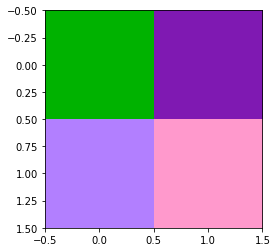

In [39]:
color = [0,0.7,0]
color2 = [0.5,0.1,0.7]
color3 = [0.7,0.5,1]
color4 = [1,0.6,0.8]
test_color = np.zeros((2,2,3))
test_color[0,0] = color
test_color[0,1] = color2
test_color[1,0] = color3
test_color[1,1] = color4
plt.imshow(test_color)

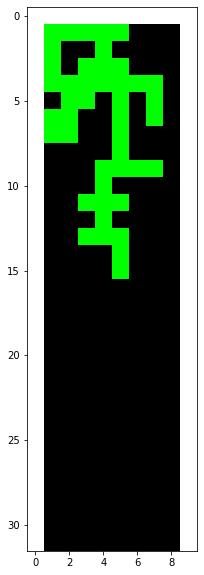

In [40]:
pattern = ">>><<><>><<<>><>>><<<>>><<<><<<>><>><<>>"
wind = list(pattern)
cave = Cave(9,2,wind)
cave.release_the_rocks(10)

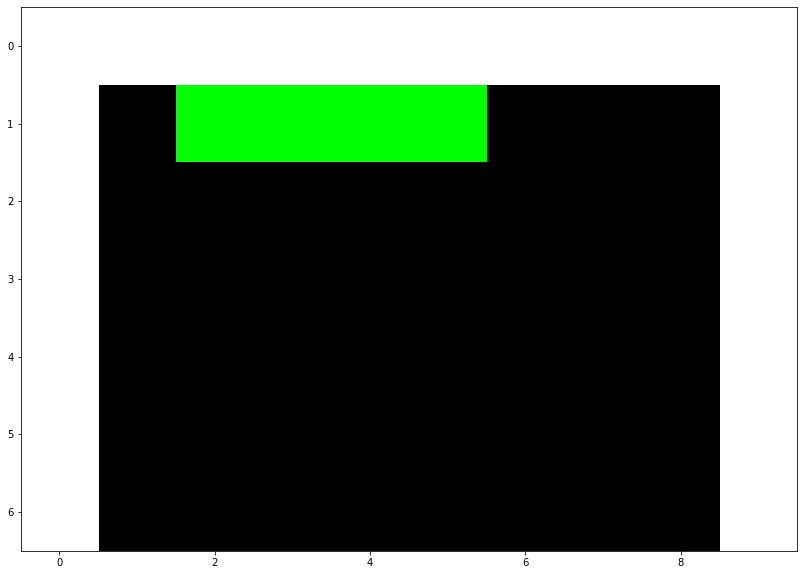

In [18]:
stone2 = Stone("-",5,cave.rock_start)

In [19]:
stone2.get_coord()

[(5, 4), (4, 4), (3, 4), (2, 4)]

In [21]:
cave.falling_stone(stone2)

IndexError: index 4 is out of bounds for axis 0 with size 3

In [224]:
log

[0,
 (False, [(5, 4), (4, 4), (3, 4), (2, 4)], [(5, 3), (4, 3), (3, 3), (2, 3)]),
 'During run n 1, check was run an gave False',
 'During run n 2, check was run an gave False',
 'During run n 3, check was run an gave False',
 'Execution ended at 4']

In [204]:
log[1][2]

[(5, 3), (4, 3), (3, 3), (2, 3)]

In [209]:
for (x,y) in log[1][2]:
    # I check if any of the next positions aren't 0, for any non-zero value False will be returned in the array,
    # resulting in the function returning False as well
    print(cave.current_image[y,x],x,y)

[0. 0. 0.] 5 3
[0. 0. 0.] 4 3
[0. 0. 0.] 3 3
[0. 0. 0.] 2 3


In [217]:
cave.remove_stone(stone.get_coord(),stone.next_coord())

In [167]:
for (x,y) in stone.get_coord():
    check = (x,y) in stone.next_coord()
    print(((x,y),check))

((5, 4), False)
((4, 4), False)
((3, 4), False)
((2, 4), False)


In [164]:
stone.next_coord()

[(5, 5), (4, 5), (3, 5), (2, 5)]

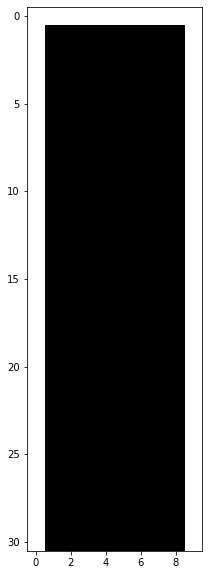

In [218]:
cave.draw_cave()

In [138]:
stone.get_coord()

[(5, 2), (4, 2), (3, 2), (2, 2)]

In [137]:
stone.set_coord()

In [13]:
# Creating the 'base' cave
height = 20
width = 9
dimensions = 3
cave = np.zeros((height,width,dimensions))

# Add white roor
for column in range(width):
    cave[0,column] = [1,1,1]

# Add white sides
for row in range(height):
    cave[row,0] = [1,1,1]
    cave[row,-1] = [1,1,1]

In [16]:
 new_cave = new_row(cave,10,9)

In [15]:
def new_row(old_cave,extra_height,width,dimensions = 3):
    extra_cave = np.zeros((extra_height,width,dimensions))
    for row in range(extra_height):
        extra_cave[row,0] = [1,1,1]
        extra_cave[row,-1] = [1,1,1]
    new_cave = np.append(old_cave,extra_cave,axis=0)
    return new_cave

In [29]:

            
            

# def add_stone(shape="-"):
    

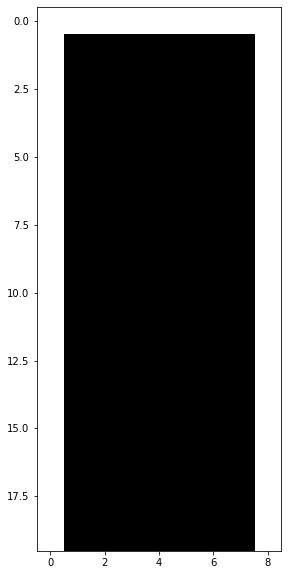

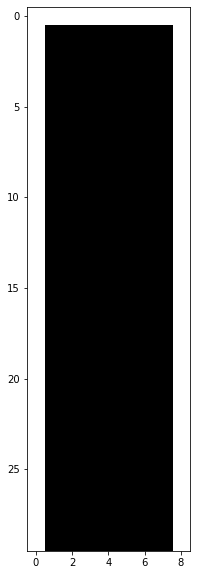

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(new_cave)
plt.show()

In [8]:
extra_cave = np.zeros((4,width,dimensions))
# for row in range(4):
#     extra_cave[row,0] = [1,1,1]
#     extra_cave[row,-1] = [1,1,1]


In [10]:
new_cave = np.append(cave,extra_cave,axis = 0)

In [78]:
for row in extra_cave:
    cave = np.append(cave,row)

In [79]:
cave

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0.

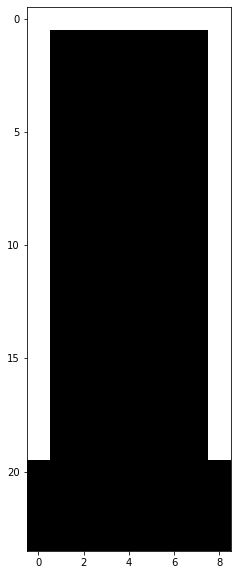

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(new_cave)
plt.show()